# **GRURec Model**

The GRURec model is an effective recommendation system capable of capturing sequential patterns and customising recommendations based on user preferences and item properties. It's been frequently used in a variety of recommendation activities.


The cold start problem occurs when the recommendation system faces difficulties with creating accurate recommendations for new users or objects with little or no historical interaction data.

GRU4Rec model itself can help in addressing the cold start problem to some extent , GRU4Rec is capable of detecting sequential patterns in user-item interactions. When new users or items with minimal interaction data are introduced, the model can use previous interactions to offer initial recommendations based on current behaviour.

**I worked on "cold_data_0.7" csv file**

import required libraries

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**load data**

In [ ]:
# Load the data
data = pd.read_csv('/kaggle/input/cold-start-07-kandeel/cold_data_0.7.csv').head(200000)

**Note**: I used a sample from data because when I use All Data , This lead to The session is Crash

**Main steps**

1- i used only from the table "user_id" , "items_id"

2- Create two instances of the LabelEncoder class called 'user_encoder' , 'item_encoder'

3- Use the 'user_encoder' to transform the values in the 'user_id' column and 'fit_transform' method fits the encoder to the unique values in the 'user_id' column

4- repeat the previos step for 'item_encoder'

5- splitting the data into two subsets, 'train_data' and 'test_data'

6- Define the GRU4Rec model with cold start handling :

   - The model takes a sequence of item indices as input and uses an embedding layer to transform them into item embeddings.

   - The embeddings are processed through a GRU layer, and item predictions can be generated using a fully connected layer.

7- hyperparameters are set for the training process of the GRU4Rec model.
   Hyperparameters are :

   - num_items: The number of unique items

   - embedding_dim: The dimension of the item embeddings

   - learning_rate: The learning rate determines the step size

   - batch_size: The number of samples

   - num_epochs : the number that determining how many times train on data

8- Convert data to tensors

9- creation of the DataLoader , after creation the model take input in form of batches


10 - The model will accept a set of input sequences, generate predictions, calculate the loss using the CrossEntropyLoss, and then backpropagate the gradients through the model to update its parameters using the Adam optimizer.

11- train and evalute the model

**Training Process**

1- defines a training on GRU4Rec model to train it on sequential item interactions.

2- During each epoch, the model makes predictions, computes the loss using CrossEntropyLoss

3- Each epoch's cumulative loss is recorded, and the average loss is calculated

4- The 'losses' list stores the average loss values for each epoch

5- make a visualization on the model's training for performance

**Evalution Process**

1- evaluation the model using model.eval()

2- use two lists (all_predictions , all_targets )to store the predicted and true target item indices

3- use test_loader to iterate over test data in batches

4- For each batch, the model predicts the next item in the sequence

5- calculate evaluation metrics: Recall@20 , Recall@5

**Visulaization**

plot the average loss during the training process over each epoch

Epoch 1/4, Average Loss: 7.9791
Recall@20: 0.5727
Recall@5: 0.4973
*********************************************
Epoch 2/4, Average Loss: 5.2716
Recall@20: 0.6714
Recall@5: 0.5949
*********************************************
Epoch 3/4, Average Loss: 4.3308
Recall@20: 0.7157
Recall@5: 0.6382
*********************************************
Epoch 4/4, Average Loss: 3.8366
Recall@20: 0.7411
Recall@5: 0.6646
*********************************************


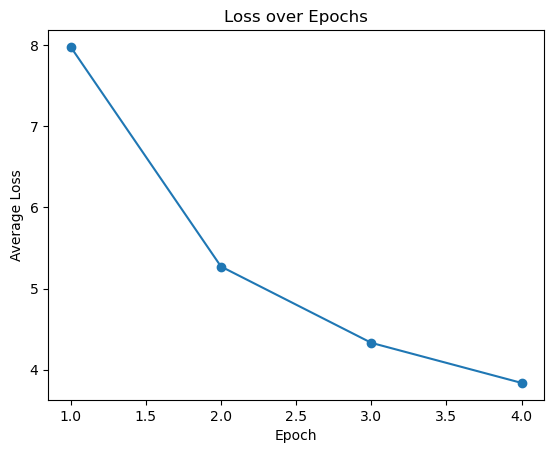

In [ ]:

# Convert user_id and item_id to numerical labels
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
data['user_id'] = user_encoder.fit_transform(data['user_id'])
data['item_id'] = item_encoder.fit_transform(data['item_id'])

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define the GRU4Rec model with cold start handling
class GRU4Rec(nn.Module):
    def __init__(self, num_items, embedding_dim):
        super(GRU4Rec, self).__init__()
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.emb_dropout = nn.Dropout(0.2)
        self.gru = nn.GRU(embedding_dim, embedding_dim, batch_first=True)
        self.fc = nn.Linear(embedding_dim, num_items)

    def forward(self, item_seq):
        item_seq_emb = self.item_embedding(item_seq)
        item_seq_emb_dropout = self.emb_dropout(item_seq_emb)
        gru_output, _ = self.gru(item_seq_emb_dropout)
        gru_output = self.fc(gru_output.squeeze(1))
        return gru_output

# Set the hyperparameters
num_items = data['item_id'].nunique()  # 30
embedding_dim = 16
learning_rate = 0.01
num_epochs = 4
batch_size = 32

# Instantiate the GRU4Rec model
model = GRU4Rec(num_items, embedding_dim)

# Convert data to tensors
X_train = torch.tensor(train_data['item_id'].values, dtype=torch.long)
X_test = torch.tensor(test_data['item_id'].values, dtype=torch.long)
y_train = torch.tensor(train_data['item_id'].values, dtype=torch.long)
y_test = torch.tensor(test_data['item_id'].values, dtype=torch.long)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for test data
test_dataset = TensorDataset(X_test.unsqueeze(1), y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Training loop
losses = []  # List to store loss values for each epoch
for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for item_seq, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(item_seq.squeeze(1))  # Reshape the input tensor
        loss = criterion(outputs.view(-1, num_items)[:batch_size], targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    losses.append(avg_loss)  # Store the loss for this epoch

    # Clear GPU Cache after each epoch
    torch.cuda.empty_cache()


# Evaluation
# Evaluation
    model.eval()
    with torch.no_grad():

        # Initialize variables to store recall@20 and recall@5
        recall_at_20 = 0.0
        recall_at_5 = 0.0

        for item_seq, targets in test_loader:
            outputs = model(item_seq.squeeze(1))
            _, predictions = torch.topk(outputs, k=20, dim=1)  # Get top 20 predictions
            predictions_at_5 = predictions[:, :5]  # Get top 5 predictions

            # Convert targets and predictions to numpy arrays
            targets = targets.numpy()
            predictions = predictions.numpy()
            predictions_at_5 = predictions_at_5.numpy()

            # Calculate recall@20 and recall@5 for each batch
            batch_recall_at_20 = np.mean([1 if target in pred else 0 for target, pred in zip(targets, predictions)])
            batch_recall_at_5 = np.mean([1 if target in pred else 0 for target, pred in zip(targets, predictions_at_5)])

            # Accumulate recall@20 and recall@5 for all batches
            recall_at_20 += batch_recall_at_20
            recall_at_5 += batch_recall_at_5

        # Calculate average recall@20 and recall@5
        avg_recall_at_20 = recall_at_20 / len(test_loader)
        avg_recall_at_5 = recall_at_5 / len(test_loader)

        print(f'Recall@20: {avg_recall_at_20:.4f}')
        print(f'Recall@5: {avg_recall_at_5:.4f}')
        print("*" * 45)

# Plot the loss
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss over Epochs')
plt.show()

**Result**


I notice that the model learn well , and the loss decrease during Evalution process over epoches and all metrices increase over epoches

- the Average Loss in Epoch 1 is  7.9791 , Recall@20: 0.5727 , Recall@5: 0.4973

- the Average Loss in Epoch 2 is  5.2716 , Recall@20: 0.6714 , Recall@5: 0.5949

- the Average Loss in Epoch 3 is  4.3308 , Recall@20: 0.7157 , Recall@5: 0.6382

- the Average Loss in Epoch 4 is  3.8366 , Recall@20: 0.7411 , Recall@5: 0.6646




**Change HyperParameters**

**I load the Data Again and change the number of samples and the number of epoches**

In [ ]:
# Load the data
data = pd.read_csv('/kaggle/input/cold-start-07-kandeel/cold_data_0.7.csv').head(300000)

Epoch 1/6, Average Loss: 7.5466
Recall@20: 0.6187
Recall@5: 0.5424
*********************************************
Epoch 2/6, Average Loss: 4.9555
Recall@20: 0.6985
Recall@5: 0.6236
*********************************************
Epoch 3/6, Average Loss: 4.1765
Recall@20: 0.7298
Recall@5: 0.6595
*********************************************
Epoch 4/6, Average Loss: 3.8485
Recall@20: 0.7417
Recall@5: 0.6715
*********************************************
Epoch 5/6, Average Loss: 3.6766
Recall@20: 0.7489
Recall@5: 0.6834
*********************************************
Epoch 6/6, Average Loss: 3.5946
Recall@20: 0.7500
Recall@5: 0.6876
*********************************************


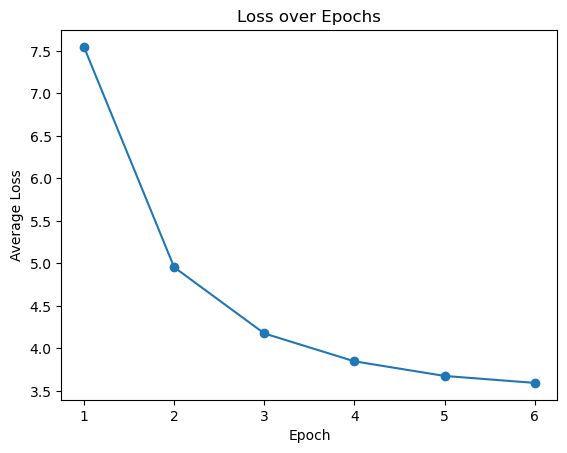

In [ ]:

# Convert user_id and item_id to numerical labels
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
data['user_id'] = user_encoder.fit_transform(data['user_id'])
data['item_id'] = item_encoder.fit_transform(data['item_id'])

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define the GRU4Rec model with cold start handling
class GRU4Rec(nn.Module):
    def __init__(self, num_items, embedding_dim):
        super(GRU4Rec, self).__init__()
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.emb_dropout = nn.Dropout(0.2)
        self.gru = nn.GRU(embedding_dim, embedding_dim, batch_first=True)
        self.fc = nn.Linear(embedding_dim, num_items)

    def forward(self, item_seq):
        item_seq_emb = self.item_embedding(item_seq)
        item_seq_emb_dropout = self.emb_dropout(item_seq_emb)
        gru_output, _ = self.gru(item_seq_emb_dropout)
        gru_output = self.fc(gru_output.squeeze(1))
        return gru_output

# Set the hyperparameters
num_items = data['item_id'].nunique()  # 30
embedding_dim = 16
learning_rate = 0.01
num_epochs = 6
batch_size = 32

# Instantiate the GRU4Rec model
model = GRU4Rec(num_items, embedding_dim)

# Convert data to tensors
X_train = torch.tensor(train_data['item_id'].values, dtype=torch.long)
X_test = torch.tensor(test_data['item_id'].values, dtype=torch.long)
y_train = torch.tensor(train_data['item_id'].values, dtype=torch.long)
y_test = torch.tensor(test_data['item_id'].values, dtype=torch.long)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for test data
test_dataset = TensorDataset(X_test.unsqueeze(1), y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Training loop
losses = []  # List to store loss values for each epoch
for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for item_seq, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(item_seq.squeeze(1))  # Reshape the input tensor
        loss = criterion(outputs.view(-1, num_items)[:batch_size], targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    losses.append(avg_loss)  # Store the loss for this epoch

    # Clear GPU Cache after each epoch
    torch.cuda.empty_cache()


# Evaluation
# Evaluation
    model.eval()
    with torch.no_grad():

        # Initialize variables to store recall@20 and recall@5
        recall_at_20 = 0.0
        recall_at_5 = 0.0

        for item_seq, targets in test_loader:
            outputs = model(item_seq.squeeze(1))
            _, predictions = torch.topk(outputs, k=20, dim=1)  # Get top 20 predictions
            predictions_at_5 = predictions[:, :5]  # Get top 5 predictions

            # Convert targets and predictions to numpy arrays
            targets = targets.numpy()
            predictions = predictions.numpy()
            predictions_at_5 = predictions_at_5.numpy()

            # Calculate recall@20 and recall@5 for each batch
            batch_recall_at_20 = np.mean([1 if target in pred else 0 for target, pred in zip(targets, predictions)])
            batch_recall_at_5 = np.mean([1 if target in pred else 0 for target, pred in zip(targets, predictions_at_5)])

            # Accumulate recall@20 and recall@5 for all batches
            recall_at_20 += batch_recall_at_20
            recall_at_5 += batch_recall_at_5

        # Calculate average recall@20 and recall@5
        avg_recall_at_20 = recall_at_20 / len(test_loader)
        avg_recall_at_5 = recall_at_5 / len(test_loader)

        print(f'Recall@20: {avg_recall_at_20:.4f}')
        print(f'Recall@5: {avg_recall_at_5:.4f}')
        print("*" * 45)

# Plot the loss
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss over Epochs')
plt.show()

**Result**

I notice that the model learn well , and the loss decrease during Evalution process over epoches and all metrices increase over epoches

- the Average Loss in Epoch 1 is 7.5466 , Recall@20: 0.6187 , Recall@5: 0.5424

- the Average Loss in Epoch 2 is 4.9555 , Recall@20: 0.6985 , Recall@5: 0.6236

- the Average Loss in Epoch 3 is 4.1765 , Recall@20: 0.7298 , Recall@5: 0.6595

- the Average Loss in Epoch 4 is 3.8485, Recall@20: 0.7417 , Recall@5: 0.6715

- the Average Loss in Epoch 5 is 3.6766 , Recall@20: 0.7489 , Recall@5: 0.6834

- the Average Loss in Epoch 6 is 3.5946 , Recall@20: 0.7500 , Recall@5: 0.6876